In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from google.colab import widgets
import time
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)


In [3]:
global gamma 
global l_r

l_r=0.01 # found this through trial and error
gamma=0.75 # found this through trial and error
Q_dict={} # My Q table is implemented as a q dictionary here
# initialize randomly
# Q table initialization
for i in range(4):
  for j in range(4):
    if i==1 and j==2: # goal states are all 0
      Q_dict[((i,j), 0)] =0
      Q_dict[((i,j),1)]=0
      Q_dict[((i,j),2)]=0
      Q_dict[((i,j),3)]=0
    else: # anything other than goal states are random
      Q_dict[((i,j), 0)] =np.random.uniform()
      Q_dict[((i,j), 1)] =np.random.uniform()
      Q_dict[((i,j), 2)] =np.random.uniform()
      Q_dict[((i,j), 3)] =np.random.uniform()
      

SARSA_dict={} 

for i in range(4):
  for j in range(4):
    if i==1 and j==2:  # goal states are all 0
      SARSA_dict[((i,j), 0)] =0
      SARSA_dict[((i,j),1)]=0
      SARSA_dict[((i,j),2)]=0
      SARSA_dict[((i,j),3)]=0
    else: # anything other than goal states are random
      SARSA_dict[((i,j), 0)] =np.random.uniform()
      SARSA_dict[((i,j), 1)] =np.random.uniform()
      SARSA_dict[((i,j), 2)] =np.random.uniform()
      SARSA_dict[((i,j), 3)] =np.random.uniform()

In [4]:


def get_max_Q(observation,Q_dict):
  (i,j)=observation
  max=-100000
  for k in range(4):
    if Q_dict[(i,j),k] > max:
      max_Q=Q_dict[(i,j),k]
      max_k=k
      max=max_Q
  return max_Q,max_k

class Environment(gym.Env):
  metadata = {'render.modes': []}
  def __init__(self): 
    self.observation_space = spaces.Discrete(16) # 4 by 4 grid # spaces is imported from gym
    self.action_space= spaces.Discrete(4) # right, left, top, bottom movement
    self.max_timesteps=10
  def reset(self):
    self.timesteps=0
    self.state= np.zeros((4,4))
    self.agent_pos= [0,0]
    self.goal_pos = tuple([1,2])
    self.state[tuple(self.agent_pos)]= 0.25 # agent start position
    self.state[tuple(self.goal_pos)]= 1 # agent goal position
    self.state[tuple([0,3])] = 0.5 # pits
    self.state[tuple([1,2])] = 0.5 # pits
    self.state[tuple([3,2])] = 0.5 #pits
    self.state[tuple([1,0])] = 0.80 # Wampus
    self.observation = self.agent_pos
    self.reward = 0
    return self.observation

  def step(self, action):
    # take the appropriate action(move right, left, down, up)
    current_agent_pos= self.agent_pos
    self.state[tuple(current_agent_pos)] = 0 # get rid of old pose
    if action ==0: #right
      self.agent_pos[0] +=1
    if action==1: #left
      self.agent_pos[0] -=1
    if action ==2: # up
      self.agent_pos[1] +=1
    if action==3: # down
      self.agent_pos[1] -=1
    #print('agent pos before clipping is {}'.format(self.agent_pos))
    self.agent_pos = np.clip(self.agent_pos, 0, 3) # clip values
    #print('agent pos after clipping is {}'.format(self.agent_pos))
    #self.state = np.zeros((4,4))
    # add original map here again
    self.state[tuple([2,0])] = 0.5 # pits
    self.state[tuple([2,2])] = 0.5 # pits
    self.state[tuple([3,3])] = 0.5 #pits
    self.state[tuple([1,0])] = 0.80 # Wampus
    self.state[tuple(self.agent_pos)]= 0.25 # add updated pose to the grid
    # do need to clear last known location of agent and add new one
    #observation = self.agent_pos 
    self.reward = 0
    if (self.agent_pos ==self.goal_pos).all(): 
      self.reward +=100 
      print("reached goal, I win")
    elif (self.agent_pos == [2,0]).all() or (self.agent_pos == [2,2]).all() or (self.agent_pos == [3,3]).all():
      print("Ohhh no I have fallen into a pit :(")
      self.reward -= 5 
    elif (self.agent_pos == [1,0]).all():
      self.reward -= 10 # wampus
    else:
      self.reward -= 1 # penalize taking too many unnedded steps
    self.timesteps += 1
    done = True if (self.timesteps>= self.max_timesteps) or (self.agent_pos == self.goal_pos).all() else False
    info = {}
    return self.agent_pos, self.reward, done, info
  def render(self): # This rendering was inspired from the TA practical session
    fig, ax= plt.subplots(figsize=(10,10))
    ax.set_xlim(0,4)
    ax.set_ylim(0,4)
    agent= AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/RL_data/agent.png'),zoom=0.36), list(map(lambda x,y: x+y , self.agent_pos, [0.5, 0.5])), frameon= False)
    pit1= AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/RL_data/pit.png'),zoom=0.36), list(map(lambda x,y: x+y , [2,0], [0.5, 0.5])), frameon= False)
    pit2= AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/RL_data/pit.png'),zoom=0.36), list(map(lambda x,y: x+y , [2,2], [0.5, 0.5])), frameon= False)
    pit3= AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/RL_data/pit.png'),zoom=0.36), list(map(lambda x,y: x+y , [3,3], [0.5, 0.5])), frameon= False)
    gold = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/RL_data/gold.png'),zoom=0.36), list(map(lambda x,y: x+y , [1,2], [0.5, 0.5])), frameon= False)
    wampus= AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/RL_data/wampus.png'), zoom=0.36), list(map(lambda x,y: x+y , [0,2], [0.5, 0.5])), frameon= False)
    ax.add_artist(agent)
    ax.add_artist(pit1)
    ax.add_artist(pit2)
    ax.add_artist(pit3)
    ax.add_artist(wampus)
    ax.add_artist(gold)
    plt.xticks([0,1,2,3])
    plt.yticks([0,1,2,3])
    plt.grid()
    plt.show()
    #plt.imshow(self.state)

class RandomAgent:
  def __init__(self, env):
    self.env= env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
  def update_Q_table(self, observation,new_observation, reward,action, Q_dict):
    
    print(observation)
    (i,j)=observation
    #print('update Q table observation is {}'.format(observation))
    #print('old Q value is {}, and action={}'.format(Q_dict[((i, j),action)], action))
    max_Q,_=get_max_Q(new_observation, Q_dict)
    Q_dict[((i, j),action)]= Q_dict[((i, j),action)] + l_r*(reward+ (gamma * max_Q) - Q_dict[((i, j),action)]) # this is updated q function
    #print('new Q value is {}, and action={}'.format(Q_dict[((i, j),action)], action))
    return Q_dict
  def step(self, observation, epsilon, Q_dict):
    # go with random action most likely when epsilon closer to 1
    # pick greedy action when epsilon closer to 0
    [i,j]=observation
    _,k=get_max_Q(observation, Q_dict)
    rand_num=np.random.choice(np.arange(0,2), p=[1-epsilon,epsilon])
    print(rand_num)
    if rand_num==1:
      return np.random.choice(self.action_space.n)
    else:
      print('going with the greedy action which is {}'.format(k))
      return k

class SARSA_Agent:
  def __init__(self, env):
    self.env= env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
  def update_Q_table(self, observation,new_observation, reward,action,action_2,SARSA_dict):
    print(observation)
    (i,j)=observation
    (i_1, j_1)=new_observation
    #max_Q,_=get_max_Q(new_observation, SARSA_dict)
    SARSA_dict[((i, j),action)]= SARSA_dict[((i, j),action)] + l_r*(reward+ (gamma *  SARSA_dict[((i_1, j_1),action_2)]) - SARSA_dict[((i, j),action)]) # this is updated q function
    return SARSA_dict

  def step(self, observation, epsilon, SARSA_dict):
    [i,j]=observation
    _,k=get_max_Q(observation, SARSA_dict)
    # go with random action most likely when epsilon closer to 1
    # pick greedy action when epsilon closer to 0
    rand_num=np.random.choice(np.arange(0,2), p=[1-epsilon,epsilon])
    if rand_num==1:
      return np.random.choice(self.action_space.n)
    else:
      print('going with the greedy action which is {}'.format(k))
      return k

def print_actions(final_action):
  if final_action==0:
    print('moving right')
  elif final_action==1:
    print('moving left')
  elif final_action==2:
    print('moving up')
  elif final_action==3:
    print('moving down')
    

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

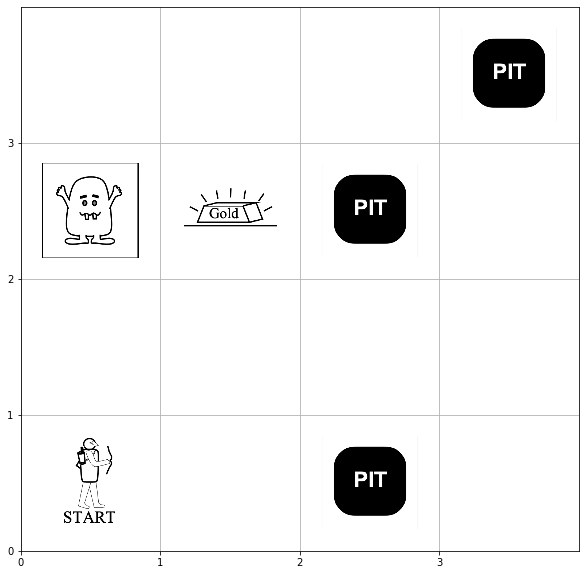

<IPython.core.display.Javascript object>

starting new episode
1
moving right
agent now in pos [1 0]
observation is [1 0]
[1 0]
1
moving down
agent now in pos [1 0]
observation is [1 0]
[1 0]
1
moving right
Ohhh no I have fallen into a pit :(
agent now in pos [2 0]
observation is [1 0]
[1 0]
1
moving left
agent now in pos [1 0]
observation is [2 0]
[2 0]
1
moving down
agent now in pos [1 0]
observation is [1 0]
[1 0]
1
moving down
agent now in pos [1 0]
observation is [1 0]
[1 0]
1
moving left
agent now in pos [0 0]
observation is [1 0]
[1 0]
1
moving left
agent now in pos [0 0]
observation is [0 0]
[0 0]
1
moving right
agent now in pos [1 0]
observation is [0 0]
[0 0]
1
moving up
agent now in pos [1 1]
observation is [1 0]
[1 0]
starting new episode
1
moving down
agent now in pos [0 0]
observation is [0 0]
[0 0]
1
moving right
agent now in pos [1 0]
observation is [0 0]
[0 0]
1
moving up
agent now in pos [1 1]
observation is [1 0]
[1 0]
1
moving up
reached goal, I win
agent now in pos [1 2]
observation is [1 1]
[1 1]
starting

In [5]:
# Q learning 
environment = Environment() # instantiate environment
agent=RandomAgent(env=environment)
observation = environment.reset()
num_episodes=100
epsilon=[1]
cumulative_reward=[]
decay_value=0.01
for i in range(num_episodes):
  new_epsilon = 1 - (i* decay_value)
  epsilon.append(new_epsilon)

output_grid= widgets.Grid(1,1)
with output_grid.output_to(0,0):
  environment.render()

for i in range(num_episodes):
  cumulative_reward.append(0)
  observation = environment.reset() # good practice to reset envioernment when instantiating it
  epsilon_value= epsilon[i]
  print('starting new episode')
  done=False
  reward=0
  while not done:
    action = agent.step(observation,epsilon_value,Q_dict) # decide on an action given current observation
    print_actions(action)
    new_observation, reward, done, info = environment.step(action) # take that action
    new_observation = np.clip(new_observation, 0, 3)
    observation = np.clip(observation, 0, 3)
    print('agent now in pos {}'.format(new_observation))
    cumulative_reward[i]= cumulative_reward[i] + reward
    print('observation is {}'.format(observation))
    Q_dict=agent.update_Q_table(observation,new_observation,reward,action, Q_dict) 
    observation=new_observation
    #with output_grid.output_to(0,0): 
    #output_grid.clear_cell()
    #environment.render()
      #time.sleep(.1)





""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

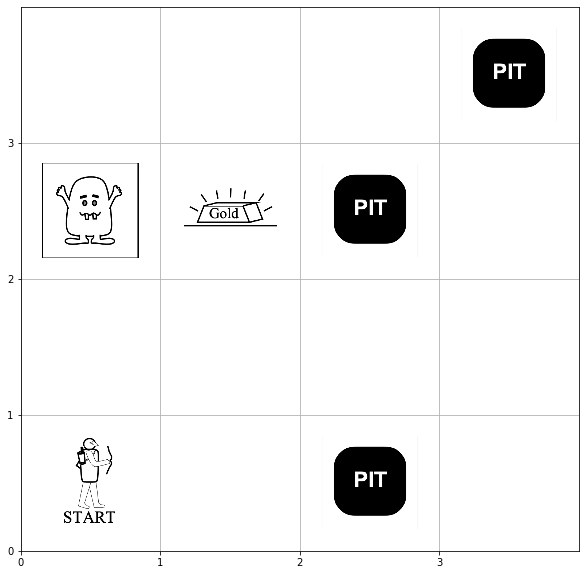

<IPython.core.display.Javascript object>

starting new episode
moving right
agent now in pos [1 0]
observation is [1 0]
[1 0]
moving right
Ohhh no I have fallen into a pit :(
agent now in pos [2 0]
observation is [1 0]
[1 0]
moving right
agent now in pos [3 0]
observation is [2 0]
[2 0]
moving right
agent now in pos [3 0]
observation is [3 0]
[3 0]
moving right
agent now in pos [3 0]
observation is [3 0]
[3 0]
moving down
agent now in pos [3 0]
observation is [3 0]
[3 0]
moving left
Ohhh no I have fallen into a pit :(
agent now in pos [2 0]
observation is [3 0]
[3 0]
moving down
Ohhh no I have fallen into a pit :(
agent now in pos [2 0]
observation is [2 0]
[2 0]
moving down
Ohhh no I have fallen into a pit :(
agent now in pos [2 0]
observation is [2 0]
[2 0]
moving up
agent now in pos [2 1]
observation is [2 0]
[2 0]
starting new episode
moving up
agent now in pos [0 1]
observation is [0 1]
[0 1]
moving right
agent now in pos [1 1]
observation is [0 1]
[0 1]
moving up
reached goal, I win
agent now in pos [1 2]
observation is 

In [6]:
# SARSA learning 
environment = Environment() # instantiate environment
agent=SARSA_Agent(env=environment)
observation = environment.reset()
num_episodes=100
epsilon=[1]
cumulative_reward_SARSA=[]
decay_value=0.01
for i in range(num_episodes):
  new_epsilon = 1 - (i* decay_value)
  epsilon.append(new_epsilon)

output_grid= widgets.Grid(1,1)
with output_grid.output_to(0,0):
  environment.render()

for i in range(num_episodes):
  cumulative_reward_SARSA.append(0)
  observation = environment.reset() # good practice to reset envioernment when instantiating it
  epsilon_value= epsilon[i]
  print('starting new episode')
  done=False
  reward=0
  while not done:
    action = agent.step(observation,epsilon_value,SARSA_dict) # decide on an action given current observation
    print_actions(action)
    new_observation, reward, done, info = environment.step(action) # take that action
    new_observation = np.clip(new_observation, 0, 3)
    observation = np.clip(observation, 0, 3)
    action_2 = agent.step(new_observation,epsilon_value,SARSA_dict) # sarsa involves doing second action according to policy
    print('agent now in pos {}'.format(new_observation))
    cumulative_reward_SARSA[i]= cumulative_reward_SARSA[i] + reward
    print('observation is {}'.format(observation))
    SARSA_dict=agent.update_Q_table(observation,new_observation,reward,action,action_2,SARSA_dict) 
    observation=new_observation
    
    #with output_grid.output_to(0,0): 
    #output_grid.clear_cell()
    #environment.render()
      #time.sleep(.1)



In [7]:
print(epsilon)

[1, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.9299999999999999, 0.92, 0.91, 0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.8200000000000001, 0.81, 0.8, 0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7, 0.69, 0.6799999999999999, 0.6699999999999999, 0.6599999999999999, 0.6499999999999999, 0.64, 0.63, 0.62, 0.61, 0.6, 0.59, 0.5800000000000001, 0.5700000000000001, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.49, 0.48, 0.47, 0.45999999999999996, 0.44999999999999996, 0.43999999999999995, 0.42999999999999994, 0.42000000000000004, 0.41000000000000003, 0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.33999999999999997, 0.32999999999999996, 0.31999999999999995, 0.30999999999999994, 0.29999999999999993, 0.29000000000000004, 0.28, 0.27, 0.26, 0.25, 0.24, 0.22999999999999998, 0.21999999999999997, 0.20999999999999996, 0.19999999999999996, 0.18999999999999995, 0.17999999999999994, 0.16999999999999993, 0.16000000000000003, 0.15000000000000002, 0.14, 0.13, 0.12, 0.10999999999999999, 0.09999999999999998, 

In [8]:
print(Q_dict)
print(SARSA_dict)

{((0, 0), 0): -1.5281173998742585, ((0, 0), 1): 0.0035179185372639765, ((0, 0), 2): 0.5526207418514184, ((0, 0), 3): 0.43038824671216136, ((0, 1), 0): 1.0657410399975389, ((0, 1), 1): 0.5831524908462951, ((0, 1), 2): 7.2569841157110035, ((0, 1), 3): -0.043409201465046655, ((0, 2), 0): 40.665459022296034, ((0, 2), 1): 1.252750970039857, ((0, 2), 2): 0.3773003926635582, ((0, 2), 3): 0.7462412291578685, ((0, 3), 0): 0.54698453839111, ((0, 3), 1): 0.4188862648844269, ((0, 3), 2): 0.470591607733042, ((0, 3), 3): 0.6148824957001046, ((1, 0), 0): -1.7353288744622934, ((1, 0), 1): 0.09562543335018454, ((1, 0), 2): 0.5745274911115522, ((1, 0), 3): -0.22717924212731833, ((1, 1), 0): 0.700681630934501, ((1, 1), 1): 0.7702951510754411, ((1, 1), 2): 14.747493382156092, ((1, 1), 3): -0.4891326097398856, ((1, 2), 0): 0, ((1, 2), 1): 0, ((1, 2), 2): 0, ((1, 2), 3): 0, ((1, 3), 0): 0.4339398633177928, ((1, 3), 1): 0.755043508785563, ((1, 3), 2): 0.06922206779471395, ((1, 3), 3): 4.670342903378888, ((2,

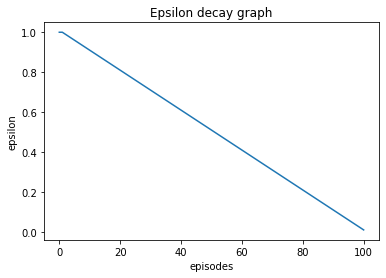

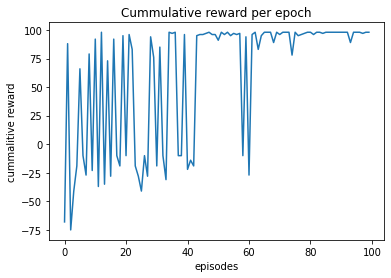

In [9]:
# graphs for Q learning
plt.plot(epsilon)
plt.xlabel('episodes')
plt.ylabel('epsilon')
plt.title('Epsilon decay graph')
plt.show()
#print(cumulative_reward)
plt.plot(cumulative_reward)
plt.xlabel('episodes')
plt.ylabel('cummalitive reward')
plt.title('Cummulative reward per epoch')
plt.show()

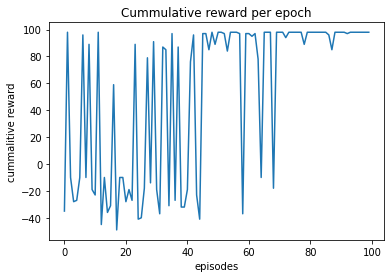

In [10]:
# graphs for SARSA
plt.plot(cumulative_reward_SARSA)
plt.xlabel('episodes')
plt.ylabel('cummalitive reward')
plt.title('Cummulative reward per epoch')
plt.show()


In [11]:
print(Q_dict) # This is the final Q table printed out

{((0, 0), 0): -1.5281173998742585, ((0, 0), 1): 0.0035179185372639765, ((0, 0), 2): 0.5526207418514184, ((0, 0), 3): 0.43038824671216136, ((0, 1), 0): 1.0657410399975389, ((0, 1), 1): 0.5831524908462951, ((0, 1), 2): 7.2569841157110035, ((0, 1), 3): -0.043409201465046655, ((0, 2), 0): 40.665459022296034, ((0, 2), 1): 1.252750970039857, ((0, 2), 2): 0.3773003926635582, ((0, 2), 3): 0.7462412291578685, ((0, 3), 0): 0.54698453839111, ((0, 3), 1): 0.4188862648844269, ((0, 3), 2): 0.470591607733042, ((0, 3), 3): 0.6148824957001046, ((1, 0), 0): -1.7353288744622934, ((1, 0), 1): 0.09562543335018454, ((1, 0), 2): 0.5745274911115522, ((1, 0), 3): -0.22717924212731833, ((1, 1), 0): 0.700681630934501, ((1, 1), 1): 0.7702951510754411, ((1, 1), 2): 14.747493382156092, ((1, 1), 3): -0.4891326097398856, ((1, 2), 0): 0, ((1, 2), 1): 0, ((1, 2), 2): 0, ((1, 2), 3): 0, ((1, 3), 0): 0.4339398633177928, ((1, 3), 1): 0.755043508785563, ((1, 3), 2): 0.06922206779471395, ((1, 3), 3): 4.670342903378888, ((2,

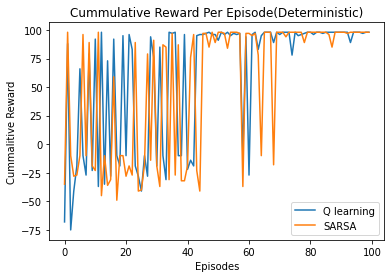

In [17]:
# Q learning and SARSA on one graph

plt.plot(cumulative_reward,label='Q learning')
plt.plot(cumulative_reward_SARSA, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Cummalitive Reward')
plt.title('Cummulative Reward Per Episode(Deterministic)')
plt.legend()
plt.show()


